In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.9MB/s  eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 45.6MB/s ta 0:00:01
    100% |████████████████████████████████| 7.3MB 7.1MB/s  eta 0:00:01
    100% |████████████████████████████████| 81kB 54.8MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 44.6MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 63.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 10.4MB 4.9MB/s  eta 0:00:01
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built holidays ujson
  Found existing installation: python-dateut

In [3]:
import gluonts
gluonts.__version__

'0.4.2'

In [4]:
import mxnet
mxnet.__version__

'1.4.1'

In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [6]:
dataname = "m4_monthly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_monthly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/test/data.json


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 48000
length test dataset 48000


In [9]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 8000.,  8350.,  8570.,  7700.,  7080.,  6520.,  6070.,  6650.,
         6830.,  5710.,  5260.,  5470.,  7870.,  7360.,  8470.,  7880.,
         6750.,  6860.,  6220.,  6650.,  5450.,  5280.,  4970.,  5550.,
         7750.,  7760.,  7190.,  7440.,  6590.,  6210.,  6010.,  6390.,
         5780.,  5700.,  4680.,  4970.,  6850.,  6740.,  7490.,  6250.,
         6900.,  5870.,  5610.,  6310.,  6110.,  6090.,  5810.,  6060.,
         6950.,  7820.,  8270.,  7840.,  7850.,  6710.,  6220.,  7430.,
         6560.,  7080.,  6680.,  6900.,  8680.,  8450.,  8670.,  8470.,
         7910.,  8140.,  7310.,  7860.,  7730.,  7330.,  7430.,  7150.,
         8720.,  8340.,  8840.,  8780.,  8250.,  8180.,  7570.,  9280.,
         9220.,  9140.,  8950.,  8540.,  9360.,  9750.,  9270.,  8690.,
         8200.,  7610.,  7160.,  8280.,  7370.,  7130.,  6840.,  7260.,
         7430.,  7950.,  7790.,  8090.,  7480.,  6700.,  6650.,  6960.,


## Plot Series

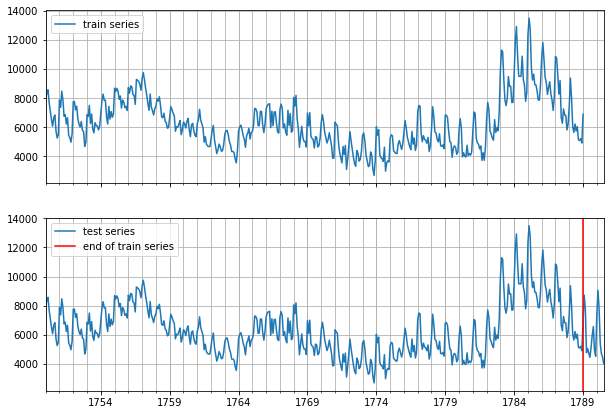

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [12]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_hourly", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_hourly


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:18<00:00, 10.68it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[0] Elapsed time 18.736 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.444627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.80it/s, avg_epoch_loss=3.89]
INFO:root:Epoch[1] Elapsed time 18.528 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.894962
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.78it/s, avg_epoch_loss=3.67]
INFO:root:Epoch[2] Elapsed time 18.551 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.668566
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.74it/s, avg_epoch_loss=3.66]
INFO:root:Epoch[3] Elapsed time 18.631 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.662680
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.80it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.85it/s, avg_epoch_loss=2.78]
INFO:root:Epoch[37] Elapsed time 18.440 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.781310
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.88it/s, avg_epoch_loss=2.75]
INFO:root:Epoch[38] Elapsed time 18.387 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.749691
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.83it/s, avg_epoch_loss=2.79]
INFO:root:Epoch[39] Elapsed time 18.471 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.787218
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.81it/s, avg_epoch_loss=2.85]
INFO:root:Epoch[40] Elapsed time 18.502 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.849780
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.77it/s, avg_epoch_loss=2.72

100%|██████████| 200/200 [00:18<00:00, 10.76it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[109] Elapsed time 18.584 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=2.301101
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:18<00:00, 10.84it/s, avg_epoch_loss=2.54]
INFO:root:Epoch[110] Elapsed time 18.456 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.543780
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:18<00:00, 10.86it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[111] Elapsed time 18.412 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.288796
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:18<00:00, 10.87it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[112] Elapsed time 18.404 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.373203
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:18<00:00, 10.82it/s, avg_epoch_loss=2.51]
INFO:root:Epoch[1

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=2.355546
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.96it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[182] Elapsed time 18.244 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=2.285666
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:17<00:00, 11.17it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[183] Elapsed time 17.901 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=2.500056
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.92it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[184] Elapsed time 18.312 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=2.322595
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.90it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[185] Elapsed time 18.346 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=2.497549
INFO:root:Epoch[186] Learning rate is 5

100%|██████████| 200/200 [00:18<00:00, 10.91it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[218] Elapsed time 18.343 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.338663
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:17<00:00, 11.13it/s, avg_epoch_loss=2.48]
INFO:root:Epoch[219] Elapsed time 17.968 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.483503
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 11.04it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[220] Elapsed time 18.120 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.364703
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 11.08it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[221] Elapsed time 18.046 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.407732
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.88it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[222] Elapsed 

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=2.414083
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.78it/s, avg_epoch_loss=2.4] 
INFO:root:Epoch[255] Elapsed time 18.556 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.402745
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.79it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[256] Elapsed time 18.537 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.331492
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.85it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[257] Elapsed time 18.441 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.433057
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.82it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[258] Elapsed time 18.480 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.318974
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:19<00:00, 10.52it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[291] Elapsed time 19.011 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.311951
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.53it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[292] Elapsed time 18.992 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.409769
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.52it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[293] Elapsed time 19.009 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.346770
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.62it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[294] Elapsed time 18.840 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.380329
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.63it/s, avg_epoch_loss=2.45]
INFO:root:Epoch[295] Elapsed 

INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=2.362498
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.79it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[328] Elapsed time 18.539 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.388941
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.76it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[329] Elapsed time 18.584 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.293227
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.68it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[330] Elapsed time 18.727 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.374248
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.71it/s, avg_epoch_loss=2.47]
INFO:root:Epoch[331] Elapsed time 18.669 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.468540
INFO:root:Epoch[332] Learning rate is 5

100%|██████████| 200/200 [00:18<00:00, 10.72it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[364] Elapsed time 18.658 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.348362
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.77it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[365] Elapsed time 18.571 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.253275
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.69it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[366] Elapsed time 18.705 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.380779
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.78it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[367] Elapsed time 18.554 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.336491
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.79it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[368] Elapsed 

Running evaluation: 100%|██████████| 414/414 [00:30<00:00, 13.73it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.096396  0.105876  20.262592            0.050981            0.050055   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:18<00:00, 10.62it/s, avg_epoch_loss=4.41]
INFO:root:Epoch[0] Elapsed time 18.826 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.413375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.72it/s, avg_epoch_loss=3.78]
INFO:root:Epoch[1] Elapsed time 18.662 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.783010
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.83it/s, avg_epoch_loss=3.59]
INFO:root:Epoch[2] Elapsed time 18.471 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.593867
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.76it/s, avg_epoch_loss=3.42]
INFO:root:Epoch[3] Elapsed time 18.597 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.418649
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.83it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.81it/s, avg_epoch_loss=2.71]
INFO:root:Epoch[37] Elapsed time 18.509 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.713880
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.84it/s, avg_epoch_loss=2.76]
INFO:root:Epoch[38] Elapsed time 18.458 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.760539
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.83it/s, avg_epoch_loss=2.7] 
INFO:root:Epoch[39] Elapsed time 18.475 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.703120
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:17<00:00, 11.13it/s, avg_epoch_loss=2.68]
INFO:root:Epoch[40] Elapsed time 17.977 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.678898
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.85it/s, avg_epoch_loss=2.84

100%|██████████| 200/200 [00:15<00:00, 13.04it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[109] Elapsed time 15.334 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=2.335066
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:15<00:00, 12.89it/s, avg_epoch_loss=2.48]
INFO:root:Epoch[110] Elapsed time 15.521 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.480045
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:15<00:00, 12.76it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[111] Elapsed time 15.670 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.356675
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:15<00:00, 13.08it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[112] Elapsed time 15.291 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.371501
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:15<00:00, 12.74it/s, avg_epoch_loss=2.44]
INFO:root:Epoch[1

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=2.447246
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.31it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[182] Elapsed time 15.024 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=2.299062
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.27it/s, avg_epoch_loss=2.46]
INFO:root:Epoch[183] Elapsed time 15.077 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=2.459442
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.00it/s, avg_epoch_loss=2.27]
INFO:root:Epoch[184] Elapsed time 15.389 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=2.271757
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 12.43it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[185] Elapsed time 16.092 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=2.429311
INFO:root:Epoch[186] Learning rate is 5

100%|██████████| 200/200 [00:14<00:00, 13.45it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[218] Elapsed time 14.872 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.352296
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.08it/s, avg_epoch_loss=2.4] 
INFO:root:Epoch[219] Elapsed time 15.288 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.404899
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.35it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[220] Elapsed time 14.983 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.332103
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.47it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[221] Elapsed time 14.847 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.366469
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.26it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[222] Elapsed 

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=2.294467
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.40it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[255] Elapsed time 14.926 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.384668
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.83it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[256] Elapsed time 14.460 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.368115
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.63it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[257] Elapsed time 14.676 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.305813
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.36it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[258] Elapsed time 14.975 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.359246
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:15<00:00, 12.81it/s, avg_epoch_loss=2.4]
INFO:root:Epoch[291] Elapsed time 15.618 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.397941
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.04it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[292] Elapsed time 15.342 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.410713
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.29it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[293] Elapsed time 15.051 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.301747
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.69it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[294] Elapsed time 14.607 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.310981
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.72it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[295] Elapsed t

INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=2.305715
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.85it/s, avg_epoch_loss=2.2] 
INFO:root:Epoch[328] Elapsed time 15.565 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.203516
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.17it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[329] Elapsed time 15.188 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.417495
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.81it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[330] Elapsed time 15.609 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.293702
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.15it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[331] Elapsed time 15.207 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.307412
INFO:root:Epoch[332] Learning rate is 5

100%|██████████| 200/200 [00:15<00:00, 12.89it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[364] Elapsed time 15.516 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.340694
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.94it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[365] Elapsed time 15.455 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.311295
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.85it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[366] Elapsed time 15.570 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.319884
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.57it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[367] Elapsed time 14.740 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.434059
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.44it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[368] Elapsed 

Running evaluation: 100%|██████████| 414/414 [00:23<00:00, 17.66it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.139156  0.106266  21.493018            0.082193             0.09106   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:16<00:00, 12.11it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[0] Elapsed time 16.522 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.539337
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.55it/s, avg_epoch_loss=3.91]
INFO:root:Epoch[1] Elapsed time 15.937 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.909322
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 13.00it/s, avg_epoch_loss=3.58]
INFO:root:Epoch[2] Elapsed time 15.386 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.575567
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:16<00:00, 12.43it/s, avg_epoch_loss=3.56]
INFO:root:Epoch[3] Elapsed time 16.086 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.560985
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.67it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.78it/s, avg_epoch_loss=2.89]
INFO:root:Epoch[37] Elapsed time 15.652 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.890037
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.88it/s, avg_epoch_loss=2.72]
INFO:root:Epoch[38] Elapsed time 15.526 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.715050
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 13.14it/s, avg_epoch_loss=2.66]
INFO:root:Epoch[39] Elapsed time 15.226 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.658566
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:14<00:00, 13.64it/s, avg_epoch_loss=2.62]
INFO:root:Epoch[40] Elapsed time 14.665 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.619717
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 13.17it/s, avg_epoch_loss=2.78

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=2.528444
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 13.29it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[74] Elapsed time 15.055 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=2.416749
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:14<00:00, 13.34it/s, avg_epoch_loss=2.46]
INFO:root:Epoch[75] Elapsed time 14.997 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=2.461528
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:14<00:00, 13.57it/s, avg_epoch_loss=2.59]
INFO:root:Epoch[76] Elapsed time 14.736 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=2.585694
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:14<00:00, 13.80it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[77] Elapsed time 14.495 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=2.501696
INFO:root:Epoch[78] Learning rate is 0.0005
100%

INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 200/200 [00:14<00:00, 13.64it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[110] Elapsed time 14.666 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.391289
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 200/200 [00:15<00:00, 13.28it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[111] Elapsed time 15.067 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.337909
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 200/200 [00:14<00:00, 13.45it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[112] Elapsed time 14.867 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.383862
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:14<00:00, 13.60it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[113] Elapsed time 14.710 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=2.422786
INFO:root:Loading parameters from best epoch (93)
INFO:root:Epoch[114] Learning rate is 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.35it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[146] Elapsed time 14.984 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=2.425731
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.70it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[147] Elapsed time 15.749 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=2.286400
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.36it/s, avg_epoch_loss=2.44]
INFO:root:Epoch[148] Elapsed time 14.973 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=2.440750
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.35it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[149] Elapsed time 14.984 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=2.338517
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:14<00:00, 13.47it/s, avg_ep

INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.341619
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.03it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[219] Elapsed time 13.311 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.287980
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.92it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[220] Elapsed time 13.402 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.314367
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.03it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[221] Elapsed time 13.306 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.377594
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.96it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[222] Elapsed time 13.368 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=2.356119
INFO:root:Epoch[223] Learning rate is 5

100%|██████████| 200/200 [00:13<00:00, 14.99it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[255] Elapsed time 13.340 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.359325
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.99it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[256] Elapsed time 13.347 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.251177
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.00it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[257] Elapsed time 13.331 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.335233
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.00it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[258] Elapsed time 13.339 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.309326
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.00it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[259] Elapsed 

INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.390114
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.01it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[292] Elapsed time 13.329 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.297803
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.06it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[293] Elapsed time 13.282 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.316392
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.03it/s, avg_epoch_loss=2.24]
INFO:root:Epoch[294] Elapsed time 13.312 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.242876
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 15.05it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[295] Elapsed time 13.294 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=2.387684
INFO:root:Epoch[296] Learning rate is 5

100%|██████████| 200/200 [00:13<00:00, 15.00it/s, avg_epoch_loss=2.26]
INFO:root:Epoch[328] Elapsed time 13.331 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.264296
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.98it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[329] Elapsed time 13.350 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.330560
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.96it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[330] Elapsed time 13.374 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.245427
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.88it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[331] Elapsed time 13.440 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.428283
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.96it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[332] Elapsed 

INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.238813
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.98it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[365] Elapsed time 13.354 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.291138
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.99it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[366] Elapsed time 13.345 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.308763
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.98it/s, avg_epoch_loss=2.24]
INFO:root:Epoch[367] Elapsed time 13.356 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.239692
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:13<00:00, 14.96it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[368] Elapsed time 13.369 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=2.357340
INFO:root:Epoch[369] Learning rate is 5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.136299  0.103567  20.780737            0.060215             0.01952   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.096396,0.105876,20.262592,0.050981,0.050055,42,400,200
0,1.139156,0.106266,21.493018,0.082193,0.091060,43,400,200
0,1.136299,0.103567,20.780737,0.060215,0.019520,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_daily


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.47it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[0] Elapsed time 7.557 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.865995
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.72it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[1] Elapsed time 7.777 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.439175
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.74it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[2] Elapsed time 7.771 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.253159
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.02it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[3] Elapsed time 7.689 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.150072
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.78it/s, avg_e

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.438132
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.77it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[37] Elapsed time 7.762 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.415165
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.05it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[38] Elapsed time 7.680 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.431236
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.94it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[39] Elapsed time 7.711 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.429202
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.83it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[40] Elapsed time 7.744 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.462094
INFO:root:Epoch[41] Learning rate is 0.001
100%|████████

100%|██████████| 200/200 [00:07<00:00, 25.85it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[109] Elapsed time 7.739 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.347565
INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 200/200 [00:07<00:00, 25.71it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[110] Elapsed time 7.779 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.343336
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 200/200 [00:07<00:00, 25.70it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[111] Elapsed time 7.784 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.327003
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 200/200 [00:07<00:00, 25.80it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[112] Elapsed time 7.754 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.362721
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:07<00:00, 25.80it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[113] 

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.06it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[145] Elapsed time 7.675 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.362348
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.77it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[146] Elapsed time 7.764 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.336364
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.76it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[147] Elapsed time 7.766 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.362326
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.42it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[148] Elapsed time 7.869 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.346776
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.91it/s, avg_epoch_

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.329818
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.86it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[182] Elapsed time 7.735 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.362196
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.51it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[183] Elapsed time 7.841 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.316510
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.73it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[184] Elapsed time 7.775 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.385541
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.89it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[185] Elapsed time 7.725 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.316449
INFO:root:Epoch[186] Learning rate is 5e-05

INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.58it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[255] Elapsed time 7.820 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.341703
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.72it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[256] Elapsed time 7.778 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.323276
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.60it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[257] Elapsed time 7.815 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.306781
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.95it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[258] Elapsed time 7.708 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.347449
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.78it/s, avg_epoch_

INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=5.339519
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.52it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[292] Elapsed time 8.160 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.327095
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.56it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[293] Elapsed time 7.825 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.318584
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.66it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[294] Elapsed time 7.797 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.307965
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.89it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[295] Elapsed time 7.728 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.343214
INFO:root:Epoch[296] Learning rate is 5e-05

INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.75it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[365] Elapsed time 7.767 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.347711
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.47it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[366] Elapsed time 7.854 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.296021
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.74it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[367] Elapsed time 7.772 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.345148
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.91it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[368] Elapsed time 7.719 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.320368
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.91it/s, avg_epoch_l

  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 245073


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.369378  0.032103  38.577975            0.028813            0.012933   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:07<00:00, 26.76it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 7.476 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.272206
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.53it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[1] Elapsed time 7.837 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.398123
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.34it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[2] Elapsed time 7.893 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.259893
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.67it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[3] Elapsed time 7.792 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.185941
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.67it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[4] Elapsed time 7.794 seconds
INFO:root:Ep

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.77it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[74] Elapsed time 7.763 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.357178
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.39it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 7.879 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.412270
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.52it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[76] Elapsed time 7.838 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.368421
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.51it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 7.843 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.400391
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.72it/s, avg_epoch_loss=5.36

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:07<00:00, 25.73it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[110] Elapsed time 7.774 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.402219
INFO:root:Loading parameters from best epoch (70)
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.57it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[111] Elapsed time 7.824 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.332104
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.79it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[112] Elapsed time 7.755 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.408665
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.17it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[113] Elapsed time 7.948 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.333739
INFO:root:Epoch[114] Learning rate is 5e-05
100%|███

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.65it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[183] Elapsed time 7.799 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.357562
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.89it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[184] Elapsed time 7.726 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.353508
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.77it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[185] Elapsed time 7.761 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.354376
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.61it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[186] Elapsed time 7.809 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.330923
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.92it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.332852
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.64it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[220] Elapsed time 7.802 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.375465
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.36it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[221] Elapsed time 7.887 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.328999
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.75it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[222] Elapsed time 7.769 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.375836
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.48it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[223] Elapsed time 7.850 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.308037
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.35it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[293] Elapsed time 7.891 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.353335
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.47it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[294] Elapsed time 7.855 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.310031
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.57it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[295] Elapsed time 7.822 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.314686
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.89it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[296] Elapsed time 7.726 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.336258
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.63it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.334614
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.71it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[330] Elapsed time 7.780 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.290434
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.54it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[331] Elapsed time 7.832 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.323623
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.34it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[332] Elapsed time 7.894 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.292817
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.75it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[333] Elapsed time 7.769 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.371616
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.276089  0.031394  39.324629            0.027701            0.012482   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:07<00:00, 26.85it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[0] Elapsed time 7.451 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.847021
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.88it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[1] Elapsed time 7.728 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.387433
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.83it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[2] Elapsed time 7.745 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.202960
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.85it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[3] Elapsed time 7.739 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.138357
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.91it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[4] Elapsed time 7.719 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:07<00:00, 25.75it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[74] Elapsed time 7.769 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.379162
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.46it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[75] Elapsed time 7.855 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.387807
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.92it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[76] Elapsed time 7.716 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.386992
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.57it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[77] Elapsed time 7.823 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.347846
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 25.92it/s, avg_epoch_loss

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.372363
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.74it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[146] Elapsed time 7.771 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.300904
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.81it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[147] Elapsed time 7.749 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.361555
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.93it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[148] Elapsed time 7.716 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.337261
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.79it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[149] Elapsed time 7.756 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.334483
INFO:root:Epoch[150] Learning rate is 5e-05


INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.69it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[219] Elapsed time 7.787 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.310173
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.71it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[220] Elapsed time 7.780 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.320141
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.36it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[221] Elapsed time 7.888 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.317403
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.75it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[222] Elapsed time 7.769 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.343203
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.63it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.333525
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.35it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[256] Elapsed time 7.891 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.294821
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.54it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[257] Elapsed time 7.833 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.366710
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.74it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[258] Elapsed time 7.770 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.293773
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.65it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[259] Elapsed time 7.798 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.350066
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.65it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[329] Elapsed time 7.800 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.353221
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.37it/s, avg_epoch_loss=5.27]
INFO:root:Epoch[330] Elapsed time 7.886 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.273025
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.55it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[331] Elapsed time 7.829 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.341216
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.93it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[332] Elapsed time 7.714 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.301040
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.66it/s, avg_epoch_l

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.304109
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.69it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[366] Elapsed time 7.785 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.310280
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.81it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[367] Elapsed time 7.749 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.296906
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.89it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[368] Elapsed time 7.725 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.327751
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.73it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[369] Elapsed time 7.774 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.286094
INFO:root:Epoch[370] Learning rate is 5e-05


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.822969  0.034721  46.19845            0.032228             0.01467    44   

   epochs  num_batches  
0     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.369378,0.032103,38.577975,0.028813,0.012933,42,400,200
0,3.276089,0.031394,39.324629,0.027701,0.012482,43,400,200
0,3.822969,0.034721,46.198450,0.032228,0.014670,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_hourly", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:13<00:00, 14.33it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[0] Elapsed time 13.960 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.444627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.42it/s, avg_epoch_loss=3.89]
INFO:root:Epoch[1] Elapsed time 13.868 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.894962
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.49it/s, avg_epoch_loss=3.67]
INFO:root:Epoch[2] Elapsed time 13.801 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.668566
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.40it/s, avg_epoch_loss=3.66]
INFO:root:Epoch[3] Elapsed time 13.889 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.662680
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.49it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.33it/s, avg_epoch_loss=2.78]
INFO:root:Epoch[37] Elapsed time 13.959 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.781310
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.45it/s, avg_epoch_loss=2.75]
INFO:root:Epoch[38] Elapsed time 13.838 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.749691
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.41it/s, avg_epoch_loss=2.79]
INFO:root:Epoch[39] Elapsed time 13.881 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.787218
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.44it/s, avg_epoch_loss=2.85]
INFO:root:Epoch[40] Elapsed time 13.856 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.849780
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:13<00:00, 14.44it/s, avg_epoch_loss=2.72

100%|██████████| 200/200 [00:13<00:00, 14.40it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[109] Elapsed time 13.889 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=2.301101
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:13<00:00, 14.47it/s, avg_epoch_loss=2.54]
INFO:root:Epoch[110] Elapsed time 13.826 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.543780
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:13<00:00, 14.50it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[111] Elapsed time 13.791 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.288796
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:13<00:00, 14.45it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[112] Elapsed time 13.845 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.373203
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:13<00:00, 14.43it/s, avg_epoch_loss=2.51]
INFO:root:Epoch[1

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=2.355546
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.67it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[182] Elapsed time 15.786 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=2.285666
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.58it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[183] Elapsed time 15.903 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=2.500056
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.96it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[184] Elapsed time 15.439 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=2.322595
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.96it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[185] Elapsed time 15.439 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=2.497549
INFO:root:Epoch[186] Learning rate is 5

100%|██████████| 200/200 [00:15<00:00, 13.31it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[218] Elapsed time 15.025 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.338663
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.90it/s, avg_epoch_loss=2.48]
INFO:root:Epoch[219] Elapsed time 15.507 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.483503
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.85it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[220] Elapsed time 15.563 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.364703
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.85it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[221] Elapsed time 15.562 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.407732
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 12.41it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[222] Elapsed 

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=2.414083
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.78it/s, avg_epoch_loss=2.4] 
INFO:root:Epoch[255] Elapsed time 15.655 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.402745
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.69it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[256] Elapsed time 15.764 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.331492
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.87it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[257] Elapsed time 15.545 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.433057
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.86it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[258] Elapsed time 15.558 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.318974
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:15<00:00, 12.65it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[291] Elapsed time 15.812 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.311951
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.72it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[292] Elapsed time 15.726 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.409769
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.58it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[293] Elapsed time 15.908 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.346770
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.50it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[294] Elapsed time 16.000 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.380329
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.88it/s, avg_epoch_loss=2.45]
INFO:root:Epoch[295] Elapsed 

INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=2.362498
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.60it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[328] Elapsed time 18.862 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.388941
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.94it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[329] Elapsed time 18.276 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.293227
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.94it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[330] Elapsed time 18.289 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.374248
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:17<00:00, 11.17it/s, avg_epoch_loss=2.47]
INFO:root:Epoch[331] Elapsed time 17.903 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.468540
INFO:root:Epoch[332] Learning rate is 5

100%|██████████| 200/200 [00:20<00:00,  9.61it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[364] Elapsed time 20.819 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.348362
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:20<00:00,  9.87it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[365] Elapsed time 20.272 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.253275
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.18it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[366] Elapsed time 19.643 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.380779
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.22it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[367] Elapsed time 19.569 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.336491
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:18<00:00, 10.74it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[368] Elapsed 

Running evaluation: 100%|██████████| 414/414 [00:31<00:00, 13.30it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.096396  0.105876  20.262592            0.050981            0.050055   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:20<00:00,  9.82it/s, avg_epoch_loss=4.41]
INFO:root:Epoch[0] Elapsed time 20.368 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.413375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:21<00:00,  9.24it/s, avg_epoch_loss=3.78]
INFO:root:Epoch[1] Elapsed time 21.647 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.783010
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:19<00:00, 10.30it/s, avg_epoch_loss=3.59]
INFO:root:Epoch[2] Elapsed time 19.414 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.593867
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:19<00:00, 10.38it/s, avg_epoch_loss=3.42]
INFO:root:Epoch[3] Elapsed time 19.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.418649
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.56it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:19<00:00, 10.28it/s, avg_epoch_loss=2.71]
INFO:root:Epoch[37] Elapsed time 19.462 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.713880
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:19<00:00, 10.30it/s, avg_epoch_loss=2.76]
INFO:root:Epoch[38] Elapsed time 19.424 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.760539
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:18<00:00, 10.75it/s, avg_epoch_loss=2.7] 
INFO:root:Epoch[39] Elapsed time 18.599 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.703120
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:20<00:00,  9.55it/s, avg_epoch_loss=2.68]
INFO:root:Epoch[40] Elapsed time 20.933 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.678898
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:21<00:00,  9.50it/s, avg_epoch_loss=2.84

100%|██████████| 200/200 [00:22<00:00,  9.01it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[109] Elapsed time 22.206 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=2.335066
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:21<00:00,  9.21it/s, avg_epoch_loss=2.48]
INFO:root:Epoch[110] Elapsed time 21.730 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.480045
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:22<00:00,  8.74it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[111] Elapsed time 22.890 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.356675
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:23<00:00,  8.54it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[112] Elapsed time 23.432 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.371501
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:24<00:00,  8.26it/s, avg_epoch_loss=2.44]
INFO:root:Epoch[1

INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=2.447246
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  9.02it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[182] Elapsed time 22.193 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=2.299062
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.60it/s, avg_epoch_loss=2.46]
INFO:root:Epoch[183] Elapsed time 23.270 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=2.459442
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  8.73it/s, avg_epoch_loss=2.27]
INFO:root:Epoch[184] Elapsed time 22.927 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=2.271757
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  8.89it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[185] Elapsed time 22.499 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=2.429311
INFO:root:Epoch[186] Learning rate is 5

100%|██████████| 200/200 [00:25<00:00,  7.86it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[218] Elapsed time 25.455 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.352296
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.99it/s, avg_epoch_loss=2.4] 
INFO:root:Epoch[219] Elapsed time 25.046 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.404899
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:24<00:00,  8.12it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[220] Elapsed time 24.642 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.332103
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.89it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[221] Elapsed time 25.354 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.366469
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.62it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[222] Elapsed 

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=2.294467
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.45it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[255] Elapsed time 26.842 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.384668
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.97it/s, avg_epoch_loss=2.37]
INFO:root:Epoch[256] Elapsed time 25.100 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.368115
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.58it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[257] Elapsed time 23.316 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.305813
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.58it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[258] Elapsed time 23.323 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.359246
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:22<00:00,  8.78it/s, avg_epoch_loss=2.4] 
INFO:root:Epoch[291] Elapsed time 22.785 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.397941
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  8.78it/s, avg_epoch_loss=2.41]
INFO:root:Epoch[292] Elapsed time 22.798 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.410713
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  8.76it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[293] Elapsed time 22.850 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.301747
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  9.00it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[294] Elapsed time 22.217 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.310981
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:21<00:00,  9.16it/s, avg_epoch_loss=2.35]
INFO:root:Epoch[295] Elapsed 

INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=2.305715
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.57it/s, avg_epoch_loss=2.2] 
INFO:root:Epoch[328] Elapsed time 26.424 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.203516
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.41it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[329] Elapsed time 27.000 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.417495
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.91it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[330] Elapsed time 25.302 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.293702
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.85it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[331] Elapsed time 25.483 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.307412
INFO:root:Epoch[332] Learning rate is 5

100%|██████████| 200/200 [00:27<00:00,  7.31it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[364] Elapsed time 27.361 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.340694
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:27<00:00,  7.37it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[365] Elapsed time 27.132 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.311295
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:27<00:00,  7.38it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[366] Elapsed time 27.100 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.319884
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.44it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[367] Elapsed time 26.887 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.434059
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:27<00:00,  7.31it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[368] Elapsed 

Running evaluation: 100%|██████████| 414/414 [00:35<00:00, 11.80it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.139156  0.106266  21.493018            0.082193             0.09106   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 56183
100%|██████████| 200/200 [00:25<00:00,  7.71it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[0] Elapsed time 25.957 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.539337
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.89it/s, avg_epoch_loss=3.91]
INFO:root:Epoch[1] Elapsed time 25.344 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.909322
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.75it/s, avg_epoch_loss=3.58]
INFO:root:Epoch[2] Elapsed time 25.821 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.575567
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.47it/s, avg_epoch_loss=3.56]
INFO:root:Epoch[3] Elapsed time 26.784 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.560985
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.56it/s, avg_epoch_l

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.76it/s, avg_epoch_loss=2.89]
INFO:root:Epoch[37] Elapsed time 25.772 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=2.890037
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.84it/s, avg_epoch_loss=2.72]
INFO:root:Epoch[38] Elapsed time 25.500 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=2.715050
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:26<00:00,  7.63it/s, avg_epoch_loss=2.66]
INFO:root:Epoch[39] Elapsed time 26.230 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=2.658566
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.87it/s, avg_epoch_loss=2.62]
INFO:root:Epoch[40] Elapsed time 25.431 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=2.619717
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:25<00:00,  7.73it/s, avg_epoch_loss=2.78

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=2.528444
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:23<00:00,  8.46it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[74] Elapsed time 23.648 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=2.416749
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:25<00:00,  7.78it/s, avg_epoch_loss=2.46]
INFO:root:Epoch[75] Elapsed time 25.703 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=2.461528
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:25<00:00,  7.77it/s, avg_epoch_loss=2.59]
INFO:root:Epoch[76] Elapsed time 25.750 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=2.585694
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:27<00:00,  7.35it/s, avg_epoch_loss=2.5] 
INFO:root:Epoch[77] Elapsed time 27.231 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=2.501696
INFO:root:Epoch[78] Learning rate is 0.0005
100%

INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 200/200 [00:24<00:00,  8.23it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[110] Elapsed time 24.318 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=2.391289
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 200/200 [00:22<00:00,  8.92it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[111] Elapsed time 22.426 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=2.337909
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 200/200 [00:22<00:00,  8.79it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[112] Elapsed time 22.758 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=2.383862
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 200/200 [00:23<00:00,  8.67it/s, avg_epoch_loss=2.42]
INFO:root:Epoch[113] Elapsed time 23.079 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=2.422786
INFO:root:Loading parameters from best epoch (93)
INFO:root:Epoch[114] Learning rate is 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.09it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[146] Elapsed time 19.825 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=2.425731
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:20<00:00,  9.77it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[147] Elapsed time 20.470 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=2.286400
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:20<00:00,  9.87it/s, avg_epoch_loss=2.44]
INFO:root:Epoch[148] Elapsed time 20.267 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=2.440750
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:21<00:00,  9.50it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[149] Elapsed time 21.051 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=2.338517
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:20<00:00,  9.60it/s, avg_ep

INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=2.341619
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.22it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[219] Elapsed time 19.577 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=2.287980
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:21<00:00,  9.35it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[220] Elapsed time 21.388 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=2.314367
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:19<00:00, 10.28it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[221] Elapsed time 19.456 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=2.377594
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:20<00:00,  9.68it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[222] Elapsed time 20.666 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=2.356119
INFO:root:Epoch[223] Learning rate is 5

100%|██████████| 200/200 [00:27<00:00,  7.36it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[255] Elapsed time 27.174 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=2.359325
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.54it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[256] Elapsed time 26.515 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=2.251177
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:27<00:00,  7.40it/s, avg_epoch_loss=2.34]
INFO:root:Epoch[257] Elapsed time 27.034 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=2.335233
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.98it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[258] Elapsed time 25.069 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=2.309326
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.59it/s, avg_epoch_loss=2.38]
INFO:root:Epoch[259] Elapsed 

INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=2.390114
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.60it/s, avg_epoch_loss=2.3] 
INFO:root:Epoch[292] Elapsed time 26.343 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=2.297803
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.66it/s, avg_epoch_loss=2.32]
INFO:root:Epoch[293] Elapsed time 26.104 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=2.316392
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.94it/s, avg_epoch_loss=2.24]
INFO:root:Epoch[294] Elapsed time 25.206 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=2.242876
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.65it/s, avg_epoch_loss=2.39]
INFO:root:Epoch[295] Elapsed time 23.120 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=2.387684
INFO:root:Epoch[296] Learning rate is 5

100%|██████████| 200/200 [00:22<00:00,  8.81it/s, avg_epoch_loss=2.26]
INFO:root:Epoch[328] Elapsed time 22.725 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=2.264296
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:24<00:00,  8.13it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[329] Elapsed time 24.603 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=2.330560
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.53it/s, avg_epoch_loss=2.25]
INFO:root:Epoch[330] Elapsed time 26.580 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=2.245427
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:26<00:00,  7.43it/s, avg_epoch_loss=2.43]
INFO:root:Epoch[331] Elapsed time 26.936 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=2.428283
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:25<00:00,  7.90it/s, avg_epoch_loss=2.33]
INFO:root:Epoch[332] Elapsed 

INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=2.238813
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.66it/s, avg_epoch_loss=2.29]
INFO:root:Epoch[365] Elapsed time 23.091 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=2.291138
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  8.81it/s, avg_epoch_loss=2.31]
INFO:root:Epoch[366] Elapsed time 22.716 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=2.308763
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:22<00:00,  9.06it/s, avg_epoch_loss=2.24]
INFO:root:Epoch[367] Elapsed time 22.092 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=2.239692
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:23<00:00,  8.65it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[368] Elapsed time 23.124 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=2.357340
INFO:root:Epoch[369] Learning rate is 5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.136299  0.103567  20.780737            0.060215             0.01952   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.096396,0.105876,20.262592,0.050981,0.050055,42,400,200
0,1.139156,0.106266,21.493018,0.082193,0.091060,43,400,200
0,1.136299,0.103567,20.780737,0.060215,0.019520,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_weekly", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 200/200 [00:09<00:00, 20.10it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[0] Elapsed time 9.956 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.079305
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.62it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[1] Elapsed time 9.254 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.620513
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.94it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 9.557 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437996
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.49it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[3] Elapsed time 9.313 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.316228
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.72it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.05it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[37] Elapsed time 11.738 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.701607
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 16.94it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[38] Elapsed time 11.810 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.713806
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.81it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[39] Elapsed time 11.234 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.743365
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:10<00:00, 19.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[40] Elapsed time 10.495 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.723811
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.10it/s, avg_epoch_loss=5.68]

INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 200/200 [00:12<00:00, 16.59it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[74] Elapsed time 12.058 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.644425
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.10it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[75] Elapsed time 11.704 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.615767
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.12it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[76] Elapsed time 11.692 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.639531
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 17.38it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[77] Elapsed time 11.515 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.631168
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:11<00:00, 16.89it/s, avg_epoch_loss=5.62

100%|██████████| 200/200 [00:09<00:00, 20.62it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[110] Elapsed time 9.699 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.565467
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 20.64it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[111] Elapsed time 9.692 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.592504
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:10<00:00, 18.67it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[112] Elapsed time 10.713 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.542513
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 20.78it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[113] Elapsed time 9.625 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.549147
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 20.33it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[114] Ela

100%|██████████| 200/200 [00:10<00:00, 18.78it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[146] Elapsed time 10.651 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.526353
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:10<00:00, 18.93it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[147] Elapsed time 10.570 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.531237
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:10<00:00, 18.71it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[148] Elapsed time 10.697 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.584246
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:10<00:00, 19.48it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[149] Elapsed time 10.272 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.551891
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:11<00:00, 18.06it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[1

INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 19.58it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[182] Elapsed time 10.220 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.557259
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 18.78it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[183] Elapsed time 10.659 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.566876
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 18.18it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[184] Elapsed time 11.005 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.514536
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 19.85it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[185] Elapsed time 10.081 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.528992
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 18.36it/s, avg_ep

INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=5.516726
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 17.44it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[255] Elapsed time 11.483 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.548040
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 17.91it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[256] Elapsed time 11.173 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.533570
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 17.53it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[257] Elapsed time 11.411 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.538203
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:11<00:00, 17.13it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[258] Elapsed time 11.700 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.556004
INFO:root:Epoch[259] Learning rate is 5

100%|██████████| 200/200 [00:07<00:00, 25.01it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[291] Elapsed time 8.000 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=5.505613
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.65it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[292] Elapsed time 8.458 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.524567
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 28.29it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[293] Elapsed time 7.073 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.525833
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.97it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[294] Elapsed time 8.347 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.521329
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.22it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[295] Elapsed time

INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.14it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[328] Elapsed time 8.289 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.505915
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.26it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[329] Elapsed time 7.921 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.529326
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.35it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[330] Elapsed time 7.893 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.530446
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.60it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[331] Elapsed time 8.477 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.531868
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.43it/s, avg_epoch_

INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=5.541754
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.93it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[365] Elapsed time 8.024 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.510825
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.36it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[366] Elapsed time 8.565 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.548025
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.80it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[367] Elapsed time 8.067 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.537181
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.66it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[368] Elapsed time 8.454 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.522015
INFO:root:Epoch[369] Learning rate is 5e-05

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.534667  0.076881  27.296198            0.058736            0.032847   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 200/200 [00:07<00:00, 25.76it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 7.767 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.254782
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.20it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[1] Elapsed time 8.267 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.605937
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.38it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[2] Elapsed time 7.882 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.398952
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 23.93it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 8.361 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.336507
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.45it/s, avg_epoch_loss=6

100%|██████████| 200/200 [00:07<00:00, 25.41it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[37] Elapsed time 7.874 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.758977
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.16it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[38] Elapsed time 7.951 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.750130
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 23.65it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[39] Elapsed time 8.459 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.737034
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.97it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[40] Elapsed time 8.012 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.747280
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.18it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[41] Elapsed time 8.273 second

INFO:root:Epoch[145] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 24.73it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[145] Elapsed time 8.089 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.539885
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 24.90it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[146] Elapsed time 8.036 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.517633
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 24.56it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[147] Elapsed time 8.145 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.536694
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 24.51it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[148] Elapsed time 8.162 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.535366
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 24.86i

INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:07<00:00, 25.12it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[185] Elapsed time 7.964 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.520062
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 22.94it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[186] Elapsed time 8.725 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.548058
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 24.42it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[187] Elapsed time 8.196 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=5.529387
INFO:root:Epoch[188] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 24.76it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[188] Elapsed time 8.079 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=5.526171
INFO:root:Epoch[189] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 23.79i

INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.20it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[258] Elapsed time 8.622 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.492544
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.79it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[259] Elapsed time 8.068 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.537164
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.82it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[260] Elapsed time 8.059 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.499073
INFO:root:Epoch[261] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.69it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[261] Elapsed time 8.103 seconds
INFO:root:Epoch[261] Evaluation metric 'epoch_loss'=5.534951
INFO:root:Epoch[262] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.45it/s, avg_epoch_l

INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.533110
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.79it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[295] Elapsed time 8.070 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.509070
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.26it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[296] Elapsed time 7.922 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.534508
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.67it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[297] Elapsed time 8.111 seconds
INFO:root:Epoch[297] Evaluation metric 'epoch_loss'=5.521812
INFO:root:Epoch[298] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.83it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[298] Elapsed time 8.055 seconds
INFO:root:Epoch[298] Evaluation metric 'epoch_loss'=5.484006
INFO:root:Epoch[299] Learning rate is 5e-05

INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.90it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[368] Elapsed time 8.035 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.495552
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.70it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[369] Elapsed time 7.785 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.503290
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.95it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[370] Elapsed time 8.354 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=5.489402
INFO:root:Epoch[371] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.28it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[371] Elapsed time 8.593 seconds
INFO:root:Epoch[371] Evaluation metric 'epoch_loss'=5.490692
INFO:root:Epoch[372] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.22it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.438226  0.076713  24.755497            0.057075            0.032199   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 200/200 [00:08<00:00, 24.66it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[0] Elapsed time 8.111 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.369380
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.98it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 8.008 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.546304
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.10it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[2] Elapsed time 7.969 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.353147
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.06it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[3] Elapsed time 7.677 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.250858
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.20it/s, avg_epoch_loss=

100%|██████████| 200/200 [00:08<00:00, 24.44it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[37] Elapsed time 8.190 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.719813
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.92it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[38] Elapsed time 8.028 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.741745
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.83it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[39] Elapsed time 7.744 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.737250
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.10it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[40] Elapsed time 7.971 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.717930
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.31it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[41] Elapsed time 8.228 second

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.545033
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 24.99it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[111] Elapsed time 8.004 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.544558
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 23.48it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[112] Elapsed time 8.519 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.561307
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 23.99it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[113] Elapsed time 8.338 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.586649
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 24.45it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[114] Elapsed time 8.183 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.527222
INFO:root:Epoch[115] Learning rate 

100%|██████████| 200/200 [00:07<00:00, 27.61it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[182] Elapsed time 7.247 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.524317
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.90it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[183] Elapsed time 8.035 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.530632
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.86it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[184] Elapsed time 8.047 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.560780
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.64it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[185] Elapsed time 8.120 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.527331
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.67it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.99it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[219] Elapsed time 8.005 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.516092
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.53it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[220] Elapsed time 8.158 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.539065
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.16it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[221] Elapsed time 8.282 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.536387
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.95it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[222] Elapsed time 8.019 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.541256
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.20it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.501815
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.90it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[256] Elapsed time 8.034 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.497512
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.91it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[257] Elapsed time 8.366 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.525011
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.26it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[258] Elapsed time 8.245 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.521464
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.33it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[259] Elapsed time 7.896 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.491367
INFO:root:Epoch[260] Learning rate is 5e-05


INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.43it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[329] Elapsed time 8.189 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.533519
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.66it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[330] Elapsed time 8.112 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.568739
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.92it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[331] Elapsed time 8.362 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.490624
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.06it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[332] Elapsed time 8.314 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.504729
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.74it/s, avg_epoch_l

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.519726
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.14it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[366] Elapsed time 8.650 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.501756
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.36it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[367] Elapsed time 8.215 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.525773
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.46it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[368] Elapsed time 7.858 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.518746
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.16it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[369] Elapsed time 8.279 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.511973
INFO:root:Epoch[370] Learning rate is 5e-05


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.45942  0.081424  24.355464            0.060078            0.034627    44   

   epochs  num_batches  
0     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.534667,0.076881,27.296198,0.058736,0.032847,42,400,200
0,2.438226,0.076713,24.755497,0.057075,0.032199,43,400,200
0,2.459420,0.081424,24.355464,0.060078,0.034627,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_yearly


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.18it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 4.242 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.478084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.88it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[1] Elapsed time 4.268 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.073184
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.29it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 4.060 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.146433
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.90it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[3] Elapsed time 4.267 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.989885
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.10it/s, avg_e

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.838901
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.47it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[37] Elapsed time 4.217 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.398767
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.18it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[38] Elapsed time 4.069 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.435832
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.17it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[39] Elapsed time 4.154 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.426155
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.19it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[40] Elapsed time 4.069 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.848712
INFO:r

INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.90it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[73] Elapsed time 4.267 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.503240
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.87it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[74] Elapsed time 4.181 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.343917
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.47it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 4.128 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.127037
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.17it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[76] Elapsed time 4.154 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.919163
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.01it/s, avg_epoch

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.12it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[146] Elapsed time 4.536 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.220299
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.57it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[147] Elapsed time 4.206 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.952714
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.50it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[148] Elapsed time 4.126 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.006584
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.23it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 3.984 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.445948
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.02it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.261986
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.42it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[183] Elapsed time 4.313 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.945264
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.66it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[184] Elapsed time 4.114 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.937402
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.78it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[185] Elapsed time 4.188 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.414743
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.77it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[186] Elapsed time 4.278 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.233048
INFO:root:Epoch[187] Learning rate is 5e-05

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.55it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[256] Elapsed time 4.298 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.060405
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.24it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[257] Elapsed time 4.327 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.375766
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.48it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[258] Elapsed time 4.214 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.238798
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.46it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[259] Elapsed time 4.047 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.656641
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.91it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.058966
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.77it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[293] Elapsed time 4.470 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.342463
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.29it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[294] Elapsed time 4.418 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.239954
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.22it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[295] Elapsed time 4.329 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.627110
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.33it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[296] Elapsed time 4.228 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.461365
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.69it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[366] Elapsed time 4.382 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.211645
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.49it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[367] Elapsed time 4.401 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.604959
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.96it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[368] Elapsed time 4.261 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.407035
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.35it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[369] Elapsed time 4.515 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.158308
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.92it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.386037  0.143401  50.133091            0.142748            0.078864   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:04<00:00, 48.27it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[0] Elapsed time 4.146 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.508818
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.48it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 4.214 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.041136
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.66it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 4.198 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.145054
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.55it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 4.208 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.969787
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.86it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[4] Elapsed time 4.181 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 47.34it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[73] Elapsed time 4.226 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.361336
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.67it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 4.111 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.430911
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.99it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[75] Elapsed time 4.260 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.314122
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.67it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[76] Elapsed time 4.197 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.803472
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.35it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[77] Elapsed time 4

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.37it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[146] Elapsed time 4.511 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.290852
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.36it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[147] Elapsed time 4.316 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.191633
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.52it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[148] Elapsed time 4.397 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.828764
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.63it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[149] Elapsed time 4.201 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.517676
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.17it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.265539
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.51it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[183] Elapsed time 4.043 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.131753
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.13it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[184] Elapsed time 4.246 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.836507
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.72it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 4.193 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.504260
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.61it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[186] Elapsed time 4.293 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.241900
INFO:root:Epoch[187] Learning rate is 5e-05


INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.47it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[256] Elapsed time 4.499 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.901017
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.43it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[257] Elapsed time 4.219 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.439848
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.50it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[258] Elapsed time 4.304 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.216490
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.62it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[259] Elapsed time 4.292 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.705225
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.00it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.089049
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.13it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[293] Elapsed time 4.245 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.361796
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.88it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[294] Elapsed time 4.364 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.227841
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.14it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[295] Elapsed time 4.337 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.639400
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.82it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[296] Elapsed time 4.274 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.418785
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.77it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[366] Elapsed time 4.190 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.227461
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.62it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[367] Elapsed time 4.587 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.679364
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.84it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[368] Elapsed time 4.183 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.397413
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.94it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[369] Elapsed time 4.356 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.180640
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.46it/s, avg_epoch_l

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.768909  0.15241  56.590887            0.150543            0.079179    43   

   epochs  num_batches  
0     400          200  
Seed: 44


100%|██████████| 200/200 [00:04<00:00, 46.24it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[0] Elapsed time 4.328 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.386168
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.07it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[1] Elapsed time 4.162 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.042467
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.72it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 4.109 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.161749
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.09it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 4.161 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.953419
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.76it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[4] Elapsed time 4.280 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 46.14it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[73] Elapsed time 4.336 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.333849
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 47.52it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[74] Elapsed time 4.211 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.371281
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 44.27it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[75] Elapsed time 4.519 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.343343
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 44.71it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[76] Elapsed time 4.475 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.795904
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.93it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 4

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.57it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[146] Elapsed time 4.703 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.307595
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.86it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[147] Elapsed time 4.460 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.982895
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.28it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[148] Elapsed time 4.519 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.892346
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.45it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 4.217 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.478130
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.08it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.236343
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.17it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[183] Elapsed time 4.243 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.938625
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.00it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[184] Elapsed time 4.171 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.917364
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.77it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[185] Elapsed time 4.189 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.459791
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.21it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[186] Elapsed time 4.331 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.217571
INFO:root:Epoch[187] Learning rate is 5e-05

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.70it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[256] Elapsed time 3.411 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.849724
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.77it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[257] Elapsed time 3.524 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.379896
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.13it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[258] Elapsed time 3.565 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.227894
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.23it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[259] Elapsed time 3.378 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.708924
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.97it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.846594
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.25it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[293] Elapsed time 3.377 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.406786
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.40it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[294] Elapsed time 3.679 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.208859
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.01it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[295] Elapsed time 3.510 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.673672
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.60it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[296] Elapsed time 3.357 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.342589
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.31it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[366] Elapsed time 3.685 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.167363
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.38it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[367] Elapsed time 3.549 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.644590
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.76it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[368] Elapsed time 3.589 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.373719
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.55it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[369] Elapsed time 3.736 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.175873
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.52it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.582839  0.148096  52.408695            0.147147            0.079506   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.386037,0.143401,50.133091,0.142748,0.078864,42,400,200
0,3.768909,0.152410,56.590887,0.150543,0.079179,43,400,200
0,3.582839,0.148096,52.408695,0.147147,0.079506,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_quarterly


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.82it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[0] Elapsed time 4.367 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.682601
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.42it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 4.219 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.187988
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.24it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[2] Elapsed time 4.063 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.209194
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.82it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[3] Elapsed time 4.274 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.109260
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.08it/s, avg_e

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.551932
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.79it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[37] Elapsed time 4.370 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.490725
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.08it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[38] Elapsed time 4.540 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.421302
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.37it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[39] Elapsed time 4.410 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.446824
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.47it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[40] Elapsed time 4.401 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.507643
INFO:root:Epoch[41] Learning rate is 0.001
100%|████████

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.338559
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.27it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 4.624 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.405519
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 43.73it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[75] Elapsed time 4.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.321777
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 45.53it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[76] Elapsed time 4.394 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.256646
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.85it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 4.181 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.381846
INFO:root:Epoch[78] Learning rate is 0.0005
100%|███

100%|██████████| 200/200 [00:04<00:00, 44.63it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[110] Elapsed time 4.483 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.332590
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 42.77it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 4.678 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.277069
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.34it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[112] Elapsed time 4.139 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.267668
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.15it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[113] Elapsed time 4.156 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.166141
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 48.35it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[114] Elap

100%|██████████| 200/200 [00:04<00:00, 47.29it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[146] Elapsed time 4.231 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.218554
INFO:root:Loading parameters from best epoch (136)
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.82it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[147] Elapsed time 4.184 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.116496
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 49.58it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[148] Elapsed time 4.036 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.279955
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 50.01it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[149] Elapsed time 4.000 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.290670
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47

100%|██████████| 200/200 [00:04<00:00, 45.90it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[182] Elapsed time 4.359 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.242320
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.29it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[183] Elapsed time 4.730 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.280467
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.79it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[184] Elapsed time 4.467 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.171752
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.07it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[185] Elapsed time 4.541 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.238548
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.89it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[186] Elapsed time

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.46it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[219] Elapsed time 4.401 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.282674
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.71it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[220] Elapsed time 4.475 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.211891
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.72it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[221] Elapsed time 4.193 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.222869
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.75it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[222] Elapsed time 4.373 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.125497
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.16it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=6.289727
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.15it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[256] Elapsed time 4.156 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.089122
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.55it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[257] Elapsed time 4.208 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.242249
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.11it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[258] Elapsed time 4.247 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.348894
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.37it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[259] Elapsed time 4.224 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.124431
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.60it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[329] Elapsed time 3.955 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.361262
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 51.00it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[330] Elapsed time 3.923 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.131797
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.01it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[331] Elapsed time 4.002 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.178850
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.51it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[332] Elapsed time 4.041 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.347704
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.95it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.244624
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.17it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[366] Elapsed time 4.529 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.259346
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.15it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[367] Elapsed time 4.863 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.217416
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.10it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[368] Elapsed time 4.643 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.118207
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.83it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[369] Elapsed time 4.366 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.195599
INFO:root:Epoch[370] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.169783  0.100679  11.356295            0.093113            0.051284   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:03<00:00, 50.20it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[0] Elapsed time 3.986 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.681406
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.07it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1] Elapsed time 4.439 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.200438
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.98it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[2] Elapsed time 4.448 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.160293
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.79it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 4.187 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.031124
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.48it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[4] Elapsed time 4.304 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:04<00:00, 48.88it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 4.093 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.450328
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 50.19it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[75] Elapsed time 3.987 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.253804
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.31it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[76] Elapsed time 4.142 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.300383
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.28it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 4.232 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.384297
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.19it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[78] Elapsed time 4.152 sec

100%|██████████| 200/200 [00:04<00:00, 45.69it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[146] Elapsed time 4.379 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.306489
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.66it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[147] Elapsed time 4.112 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.191213
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.82it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[148] Elapsed time 4.184 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.318157
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.57it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[149] Elapsed time 4.206 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.344681
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.01it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.14it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[183] Elapsed time 4.156 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.279310
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.34it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[184] Elapsed time 4.139 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.227178
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.18it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[185] Elapsed time 4.241 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.322632
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.24it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[186] Elapsed time 4.235 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.228485
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.97it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.310759
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.97it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[220] Elapsed time 4.086 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.299548
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.01it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[221] Elapsed time 4.001 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.274790
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.37it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[222] Elapsed time 3.972 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.157576
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.28it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[223] Elapsed time 4.060 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.273489
INFO:root:Epoch[224] Learning rate is 5e-05


INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.14it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[293] Elapsed time 3.991 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.103793
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.52it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[294] Elapsed time 4.041 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.274923
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.87it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[295] Elapsed time 4.094 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.304527
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.35it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[296] Elapsed time 3.974 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.302676
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.39it/s, avg_epoch_los

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.291084
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.02it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[330] Elapsed time 4.255 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.249788
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.72it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[331] Elapsed time 4.282 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.138185
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.86it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[332] Elapsed time 4.363 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.244518
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.48it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[333] Elapsed time 4.045 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.308465
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.146497  0.099863  11.775173            0.092389            0.050972   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:04<00:00, 47.81it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 4.190 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.762774
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.33it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 4.228 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.179286
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.43it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 4.309 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.192251
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.47it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[3] Elapsed time 4.045 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.076519
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.21it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[4] Elapsed time 4.150 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 47.18it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[37] Elapsed time 4.241 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.531206
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.02it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[38] Elapsed time 4.168 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.403044
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.81it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[39] Elapsed time 4.017 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.504281
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.15it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 4.243 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.563814
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.20it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[41] Elapsed time 4.151 seco

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.90it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 4.266 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.441209
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 44.17it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[75] Elapsed time 4.530 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.367613
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.28it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 4.325 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.432157
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 45.99it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[77] Elapsed time 4.351 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.405882
INFO:root:Epoch[78] Learning rate is 0.000125
100%|████

100%|██████████| 200/200 [00:04<00:00, 45.13it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 4.433 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.418145
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 45.25it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[111] Elapsed time 4.422 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.468659
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.32it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[112] Elapsed time 4.228 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.409593
INFO:root:Loading parameters from best epoch (102)
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.19it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[113] Elapsed time 4.428 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.272770
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.84it/

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.287673
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.39it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[147] Elapsed time 4.223 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.305653
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.35it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 4.055 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.454384
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.80it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[149] Elapsed time 4.276 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.354123
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.00it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[150] Elapsed time 4.083 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.271050
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.58it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[220] Elapsed time 4.122 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.401159
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.35it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[221] Elapsed time 3.974 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.359133
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.31it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[222] Elapsed time 4.060 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.250476
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.51it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[223] Elapsed time 4.302 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.351729
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.80it/s, avg_epoch_l

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.401925
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.30it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[257] Elapsed time 3.978 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.290239
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.63it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[258] Elapsed time 4.291 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.323051
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.49it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[259] Elapsed time 4.043 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.228473
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.24it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[260] Elapsed time 3.983 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.350620
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.49it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[330] Elapsed time 4.043 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.239639
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.34it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[331] Elapsed time 4.055 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.342179
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.50it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[332] Elapsed time 4.042 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.276690
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.62it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[333] Elapsed time 4.115 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.280707
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.71it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.337360
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.43it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[367] Elapsed time 4.218 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.307768
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.15it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[368] Elapsed time 4.243 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.219794
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.34it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[369] Elapsed time 4.512 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.307045
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.78it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[370] Elapsed time 4.571 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.353640
INFO:root:Epoch[371] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.184236  0.102078  11.40622            0.094814            0.052732    44   

   epochs  num_batches  
0     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.169783,0.100679,11.356295,0.093113,0.051284,42,400,200
0,1.146497,0.099863,11.775173,0.092389,0.050972,43,400,200
0,1.184236,0.102078,11.406220,0.094814,0.052732,44,400,200
